# Group Meeting 5

Information Dynamics, Active Information Storage

### Readings 

N/A

## Information Dynamics

What does it mean to say that a complex systems "computes" or "performs computation?" The question of "what is computation" is a deep philosophical one, however I like Melanie Mitchell's definition: "computation is dynamics with purpose". We say that a system is "computing" if it's next state is a function of some combination of it's own past state and/or the past-states of some set of inputs. 

In this way, we might think of a system moving towards an attractor to be "computing" it's own long-term behavior. Alternately, in a system that takes in defined inputs and updates it's own state accordingly, it's performing some kind of "computation" on the inputs. 

If we take this (admittedly) expansive definition of computation, we see that computation is ubiquitous in complex systems - neural networks are obviously updating their internal states based on the states of other neurons, but so are companies in an economic system and participants in a social media ecosystem. Consider an IPO for a new company: the price of the stock at the end of the IPO reflects the collective choices of all the players in the market and (in theory) we can think of the market as "computing" the value of the company (of course, real economic systems are much more complex than this, but it's a nice toy example). 

Crucially, this is *distributed computation* - normally we think of computation as taking place in a single element (a logic gate, for instance), however a complex system with massive numbers of elements will compute it's own future through the synergistic and redundant interaction between subsets. This requires that information flows through the system, and that the elements themselves use information about other components to inform their subsequent behavior. In the IPO example, prospective investors will see that people are rushing to buy, driving up the price and increasing the probability that they will buy. 

When "computation" is occuring in complex systems researchers typically break it down into several components, inspired by artificial computation in silicon computers. Information can variously be:

1) Stored (as in RAM) - information remains retreavable from a single element of the system. 

2) Transfered (as in relays) - information moves from one element of the system to another. 

3) Modified - this is a core essence of computation, and not well-defined. 

### Information Storage

Here we are looking at information storage, specfically information that is "actively" stored, as opposed to information that is being "written" to a physical substrate. Consider the difference between information that is on a CD vs. that same information when it is loaded into RAM and interfacing with the operating system. 

For a system $X$, active information storage (AIS) of order $k$ is generally defined as the mutual information between the *past* of the system (going back $k$-timesteps) and the immediate next state:

\begin{equation}
AIS(X_t) = MI(X_{t-1}^{-k} ; X_t)
\end{equation}

Another way of thinking about this is as a measure of how much information knowing the past $k$ states of the system gives you about the future (compare this to the information innovation rate introduced in the last section). Note that the AIS does not give you any information about how information may be flowing into, or out of, $X$ - it is only interested in that information about the future that is predictable from $X$'s past.

Let's consider some data, in this case, binarized fMRI BOLD signals:

Text(0.5, 1.0, 'Sample BOLD Time-Series')

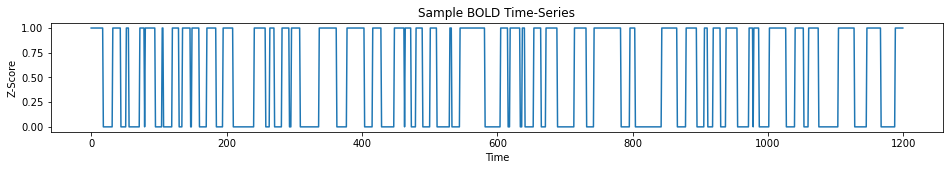

In [56]:
import numpy as np 
from scipy.stats import entropy
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.stats import zscore
from collections import Counter
import networkx as nx

data = np.load("data/HCP_BOLD.npz")
bold = zscore(data["signal"], axis=1) #Z-scored for data-hygiene reasons.
bold[bold < 0] = int(0)
bold[bold > 0] = int(1)

bold=bold.astype("int")

plt.figure(figsize=(16,2))
plt.plot(bold[0][:])
plt.xlabel("Time")
plt.ylabel("Z-Score")
plt.title("Sample BOLD Time-Series")

We want to know how the value of $k$ changes AIS. It's easiest to start with $k=1$, this corresponds to just duplicated the time-series with an offset of 1. 

In [36]:
#When K=1
pres = bold[0][1:]
past = bold[0][:-1]

H_pres = entropy(list(Counter(pres).values()), base=2)
H_past = entropy(list(Counter(past).values()), base=2)
H_joint = entropy(list(Counter(zip(pres, past)).values()), base=2)

print("MI, k=1:", round(H_pres+H_past-H_joint, 4), "bit")

MI, k=1: 0.6191 bit


Not a tremendous amount of information. Knowing the past is definitely better than guessing randomly (which would be 0 bit) but also definitely not providing a ton of certainty either. To explore higher k, it will be useful to write a function that will generalize:

In [61]:
def ais(X, k=3, unique=False):
    pres = X[k:]
    past = ["".join((str(i) for i in bold[0][j:j+k])) for j in range(bold[0].shape[0]-k)]
    unique_past = {x for x in past}
    
    
    H_pres = entropy(list(Counter(pres).values()), base=2)
    H_past = entropy(list(Counter(past).values()), base=2)
    H_joint = entropy(list(Counter(zip(pres, past)).values()), base=2)
    
    if unique == False:
        return H_pres+H_past-H_joint
    elif unique == True:
        return H_pres+H_past-H_joint, unique_past

We can then iterate through $k$ and watch how AIS grows (it will only ever grow as no information about the past will make it harder to predict the future). 

Text(0, 0.5, 'Time')

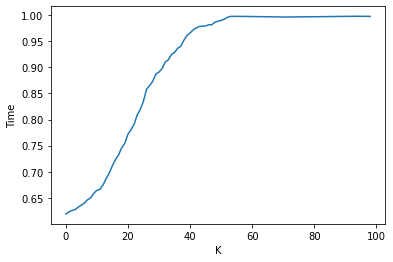

In [52]:
ais_range = [ais(bold[0],k) for k in range(1,100)]
plt.plot(ais_range)
plt.xlabel("K")
plt.ylabel("Time")

I went to 100 to illustrate the point that AIS will saturate given enough time. However, that doesn't mean that we should always crank $k$ up as high as it can possibly go. Consider what it means to have a history of $k=100$. That means that there are $2^{100}$ possible pasts and we a little less than $2^{10}$ observations of our system. Consequently, we are only sampling $8\times10^{-26}\%$ of our possible state-space. 

Consequently, every past state/future state combination only appears once, giving the illusion of total predictive power but it's only because your state-space is so dreadfully undersampled. There are no instances of the same past state leading to different future states - everything appears to be deterministic. 

We can ask when the system becomes so undersampled as to be useless. Below we plot AIS for the same time-series, with $k$ running from 1 to 20, and we will plot the proportion of the possible state-space explored.  

In [77]:
ais_range_2 = [ais(bold[0],k, True) for k in range(1,20)]
ais_val, unique_sets = zip(*ais_range_2)
powers_2 = [2**x for x in range(1,20)]

sample_space = [len(unique_sets[i]) / powers_2[i] for i in range(len(powers_2))]

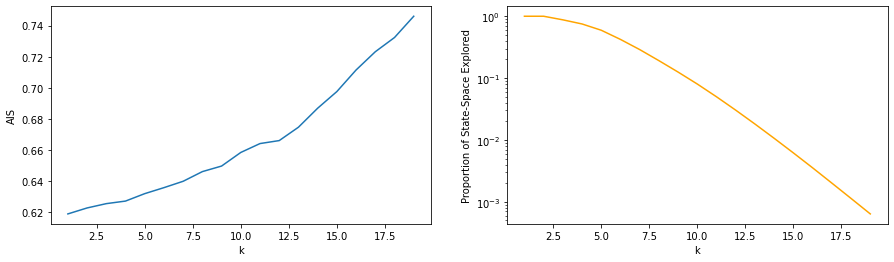

In [92]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(np.arange(1,len(ais_val)+1),ais_val)
plt.xlabel("k")
plt.ylabel("AIS")

plt.subplot(1,2,2)
plt.plot(np.arange(1,len(ais_val)+1),sample_space, color="orange")
plt.xlabel("k")
plt.ylabel("Proportion of State-Space Explored")
plt.yscale("log")

So, what $k$ should you pick? There isn't always a *best* choice - you need to ensure that you pick a large enough $k$ that you don't underestimate the AIS (that is to say, you miss out on some information). On the flip side, you can't pick too large a space that the sample-space is unresolvable (in which case, you will over-estimate AIS because the system will appear deterministic). 

### Information Transfer

In addition to knowing how information is stored in a single variable, we might also be interested in how information is transfered from a source ($X$) at time $t$, to a target ($Y$) at time $t+1$. The simplest possibility is to look at the mutual information between between the past of $X$ and the immediate future of $Y$:

\begin{equation}
MI(X_{t-1}^{-k}, Y_t)
\end{equation}

This gives us a measure of how much information about the past of $X$ gives us about $Y$'s next state. The problem with this simplistic measure, however, is that it conflates information being transfered from $X$ to $Y$, with information that is actively stored in $Y$ and $X$ seperately. Consider the case of two uncoupled variables that osscilate with $\sin(t)$ and $\cos(t)$ respectively:

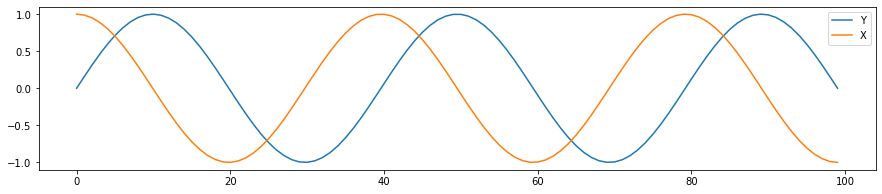

In [10]:
sin = np.sin(np.linspace(0, np.pi*5, 100))
cos = np.cos(np.linspace(0, np.pi*5, 100))

plt.figure(figsize=(15,3))
plt.plot(sin, label="Y")
plt.plot(cos, label="X")
plt.legend()

Because $X$ is always "lags" $Y$ by some multiple of $\pi$ and they are identical curves, the mutual information between the two is quite high. Knowing the past of $X$ gives you a lot of insight into what $Y$ is going to do in the future. 

The problem, of course is that knowing $Y$'s past by itself *also* gives you signficant insights into it's own future. In truth, $X$ and $Y$ are totally independent, the non-trivial, time-lagged mutual information is an artifact of a *common driver effect*. What we want, then, is a measure that tells us *how much better are we at predicting Y's future when we know the past of X than we would be if we just knew the past of Y?*. 

In the sine/cosine case, it's clear that this value would be low. All you need is $Y$'s own past, $X$ provides nothing *above and beyond* what Y does. This brings us to *Transfer Entropy*

#### Transfer Entropy

The transfer entropy is given by a conditional mutual information: the time-lagged MI between $X$'s past and $Y$'s future, *conditioned* on $Y$'s past.

\begin{equation}
TE(X \rightarrow Y) = MI(X_{t-1}^{-l} ; Y_t | Y_{t-1}^{-k})
\end{equation}

Transfer entropy is *high* when the past of $X$ is very informative about the future state of $Y$, but $Y$ itself is minimally informative.

Consider the case where $X$ is a random number generator and $Y$ always copies $X$ at the time-step. Knowing the past of $X$ gives you total certainty about the future of $Y$, however, $Y$'s own past is minimally informative, since it just copies $X$ at time $t-1$ without paying any attention to it's own previous state.

#### Computing TE

When computing the transfer entropy between two variables, it is vitally important to have a valid null model against which to compare the empirical value. 
The general algorithm for pairwise TE is:

1) Select optimal value of $k$ to construct the embedded $Y_{t-1}^{-k}$. This can be thought of as optimizing the active information storage so that we get *as much predictive power from $Y$'s own past as possible*. Keep in mind that we are trying to balance the history taken into account with the amount of available data. 

2) Select optimal value of $l$ to construct the embedded $X_{t-1}^{-l}$. This can be thought of as optimizing *the amount of predictive power from $X$'s past about $Y$'s future*. Keep in mind that we are trying to balance the history taken into account with the amount of available data.

3) Calculate the empirical $TE(X \rightarrow Y)$

4) You now need to create a null distribution against which you can significance-test your empirical TE value. This usually entails randomizing the *source* time-series (so as to preserve the autocorrelation of the reciever). There are a lot of considerations about how best to do this - I generally recommend "rolling" the source-time-series (offsetting every time-point by a fixed $n$), which preserves the autocorrelation of the source series while (in theory) breaking any association between source and target. 

5) Calculate the null TE, and do this 1000+ times to build up a distribution of possible null values (remember to randomize the source-time-series every time!).

6) If your empirical TE is greater than some pre-determined percentage of the null TEs, you conclude statistical significance and your empirical TE is "real."


### Information Modification

Of the three major components of information dynamics, this is the one that has had the most difficulty being successfully formalized. Information storage is quantified using AIS, and information transfer is quantified using TE. Information modification, however, has resisted attempts to move beyond heuristics. One promising, graph-based approach is to consider the case when multiple inputs feed into a single element, which produces some kind of output based on the joint-states of all inputs. 

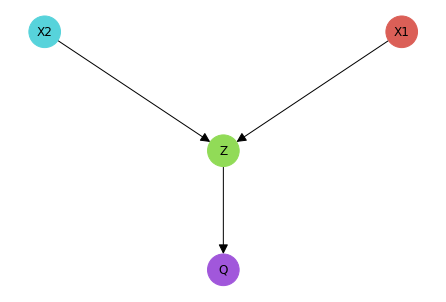

In [97]:
import seaborn as sns
G = nx.DiGraph([("X1","Z"),("X2","Z"),("Z","Q")])
nx.draw_kamada_kawai(G,
                     with_labels=True, 
                     node_color=sns.palettes.hls_palette(4),
                     node_size=10**3,
                     arrowsize=20
                    )

Presumably $Z$ is performing some kind of *computation* on the states of $X_1$ and $X_2$. In the simplest case, $Z$ might just ignore either $X_1$ or $X_2$ and simply serve as a relay, in which case information is not modified, but rather, just transfered. 

Alternately, $Z$ may implement some kind of Boolean function (assuming all elements are binary), which is sensitive to the joint states of both parents. If $Z$ depends, in all (or nearly all) cases on the joint states of both parents to decide what it's next state is, then we would say it performs a kind of *synergistic computation*, in which the information in $X_1$ and $X_2$ is modified by way of synergistic combination. 
